- We prepare a dataset of speech samples from different speakers, with the speaker as label.
- We add background noise to these samples to augment our data.
- We take the FFT of these samples.
- We train a 1D convnet to predict the correct speaker given a noisy FFT speech sample.

## Setup

In [59]:
import os
import shutil
import numpy as np

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio

DATASET_AUDIO_PATH = "audio"
DATASET_NOISE_PATH = "noise"

# Percentage of samples to use for validation
VALID_SPLIT = 0.1

# Seed to use when shuffling the dataset and the noise
SHUFFLE_SEED = 43

SAMPLING_RATE = 16000

# The factor to multiply the noise with according to:

SCALE = 0.5

BATCH_SIZE = 100
EPOCHS = 25


## Data preparation

The dataset is composed of 7 folders, divided into 2 groups:

- Speech samples, with 5 folders for 5 different speakers. Each folder contains
300 audio files, each 2 second long and sampled at 16000 Hz.
- Background noise samples, with 2 folders and a total of 6 files. These files
are longer than 1 second (and originally not sampled at 16000 Hz, but we will resample them to 16000 Hz).
We will use those 6 files to create 354 1-second-long noise samples to be used for training.

Let's sort these 2 categories into 2 folders:

- An `audio` folder which will contain all the per-speaker speech sample folders
- A `noise` folder which will contain all the noise samples

## Noise preparation

In this section:

- We load all noise samples (which should have been resampled to 16000)
- We split those noise samples to chunks of 16000 samples which
correspond to 1 second duration each

In [60]:
# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

Found 6 files belonging to 2 directories


In [61]:
noise_paths

['noise\\other\\exercise_bike_1.wav',
 'noise\\other\\pink_noise_1.wav',
 'noise\\_background_noise_\\10convert.com_Audience-Claps_daSG5fwdA7o_1.wav',
 'noise\\_background_noise_\\doing_the_dishes_1.wav',
 'noise\\_background_noise_\\dude_miaowing_1.wav',
 'noise\\_background_noise_\\running_tap_1.wav']

In [62]:
import librosa
x,sr = librosa.load('noise/other/exercise_bike_1.wav')
print(x.shape)
print(sr)

(1350648,)
22050


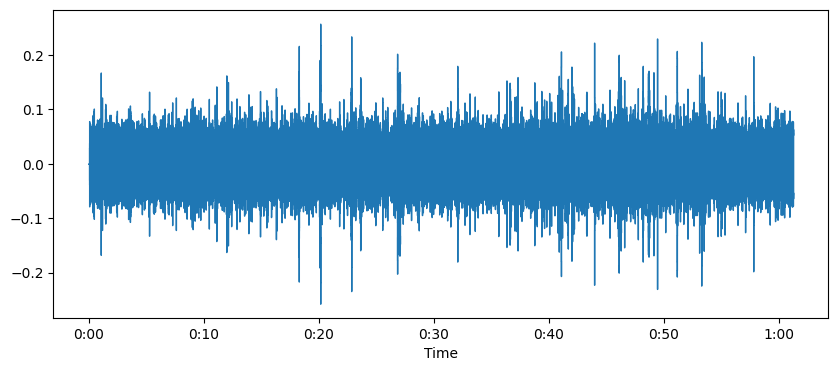

In [63]:
import matplotlib.pyplot as plt
import librosa.display
plt.figure(figsize=(10, 4))
librosa.display.waveshow(x,sr=sr)

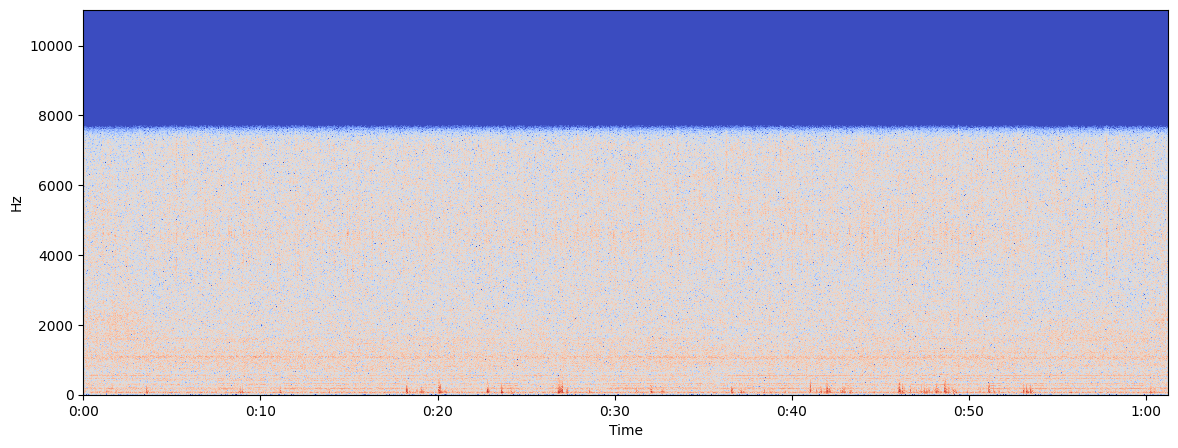

In [64]:
x = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(x))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [65]:
import IPython.display as ipd
ipd.Audio('noise/other/exercise_bike_1.wav')

Resample all noise samples to 16000 Hz

In [66]:
# Split noise into chunks of 16000 each
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    print('sampling rate of original audio', sampling_rate)
    if sampling_rate == SAMPLING_RATE:
        print('shape',sample.shape[0])
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / sampling_rate)
        print(slices)
        sample = tf.split(sample[: slices * sampling_rate], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 980062
61
sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 960000
60
sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 260685
16
sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 1522930
95
sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 988891
61
sampling rate of original audio tf.Tensor(16000, shape=(), dtype=int32)
shape 978488
61


In [67]:
noises

<tf.Tensor: shape=(354, 16000, 1), dtype=float32, numpy=
array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.00726318],
        [ 0.00836182],
        [ 0.03463745]],

       [[ 0.02310181],
        [ 0.02258301],
        [ 0.03710938],
        ...,
        [ 0.0461731 ],
        [ 0.01617432],
        [-0.00595093]],

       [[ 0.02731323],
        [ 0.00082397],
        [-0.02474976],
        ...,
        [ 0.02902222],
        [ 0.00637817],
        [ 0.02310181]],

       ...,

       [[-0.17156982],
        [-0.01519775],
        [ 0.01150513],
        ...,
        [-0.0229187 ],
        [-0.08718872],
        [-0.05444336]],

       [[ 0.03308105],
        [ 0.02026367],
        [-0.0562439 ],
        ...,
        [-0.11154175],
        [-0.06661987],
        [ 0.09057617]],

       [[-0.06546021],
        [ 0.03704834],
        [ 0.00875854],
        ...,
        [ 0.00512695],
        [-0.0737915 ],
        [ 0.10592651]]], dtype=float3

## Dataset generation

In [68]:

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio


def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio


def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])


# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)


# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

Our class names: ['Badhan_Halder', 'Imtiaz', 'Nainaiu', 'Ohee', 'Rejoyan']
Processing speaker Badhan_Halder
Processing speaker Imtiaz
Processing speaker Nainaiu
Processing speaker Ohee
Processing speaker Rejoyan
Found 2500 files belonging to 5 classes.
Using 2250 files for training.
Using 250 files for validation.


## Model Definition

In [69]:

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)


model = build_model((SAMPLING_RATE // 2, 1), len(class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 8000, 1)]            0         []                            
                                                                                                  
 conv1d_55 (Conv1D)          (None, 8000, 16)             64        ['input[0][0]']               
                                                                                                  
 activation_39 (Activation)  (None, 8000, 16)             0         ['conv1d_55[0][0]']           
                                                                                                  
 conv1d_56 (Conv1D)          (None, 8000, 16)             784       ['activation_39[0][0]']       
                                                                                            

## Training

In [70]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 1.9391 - accuracy: 0.5076

c:\Users\naina\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 111s 4s/step - loss: 1.9391 - accuracy: 0.5076 - val_loss: 1.2822 - val_accuracy: 0.5640
Epoch 2/25
23/23 [==============================] - 99s 4s/step - loss: 0.6015 - accuracy: 0.7778 - val_loss: 0.4186 - val_accuracy: 0.8600
Epoch 3/25
23/23 [==============================] - 87s 4s/step - loss: 0.3741 - accuracy: 0.8689 - val_loss: 0.3453 - val_accuracy: 0.8840
Epoch 4/25
23/23 [==============================] - 87s 4s/step - loss: 0.3098 - accuracy: 0.8991 - val_loss: 0.4336 - val_accuracy: 0.8480
Epoch 5/25
23/23 [==============================] - 86s 4s/step - loss: 0.2557 - accuracy: 0.9147 - val_loss: 0.3218 - val_accuracy: 0.8840
Epoch 6/25
23/23 [==============================] - 87s 4s/step - loss: 0.2127 - accuracy: 0.9222 - val_loss: 0.4404 - val_accuracy: 0.8640
Epoch 7/25
23/23 [==============================] - 87s 4s/step - loss: 0.1854 - accuracy: 0.9409 - val_loss: 0.2288 - val_accuracy: 0.9240
Epoch 8/25
23/23 [============

## Evaluation

In [71]:
print(model.evaluate(valid_ds))

8/8 [==============================] - 3s 304ms/step - loss: 0.2842 - accuracy: 0.9160
[0.2841768264770508, 0.9160000085830688]


## Demonstration

Let's take some samples and:

- Predict the speaker
- Compare the prediction with the real speaker
- Listen to the audio to see that despite the samples being noisy,
the model is still pretty accurate

In [75]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=SCALE), y))

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

4/4 [==============================] - 1s 223ms/step
Speaker: Badhan_Halder	Predicted: Badhan_Halder


Speaker: Nainaiu	Predicted: Nainaiu


Speaker: Rejoyan	Predicted: Rejoyan


Speaker: Nainaiu	Predicted: Nainaiu


Speaker: Ohee	Predicted: Ohee


Speaker: Imtiaz	Predicted: Imtiaz


Speaker: Badhan_Halder	Predicted: Badhan_Halder


Speaker: Nainaiu	Predicted: Nainaiu


Speaker: Nainaiu	Predicted: Nainaiu


Speaker: Imtiaz	Predicted: Imtiaz


## Prediction

In [76]:
class_names = ['Badhan_Halder', 'Imtiaz', 'Nainaiu', 'Ohee', 'Rejoyan']

custom_audio_path = 'extra/Nainaiu_001.wav'
# Preprocess the custom audio
def preprocess_custom_audio(path):
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio

def predict(audio_tuple):
    preprocessed_audio = preprocess_custom_audio(audio_tuple)
    audio_batch = np.expand_dims(preprocessed_audio, axis=0)
    audio_fft = audio_to_fft(audio_batch)
    predictions = model.predict(audio_fft)
    predicted_class_index = np.argmax(predictions[0])
    
    # Get the predicted class label using the index
    if predictions[0][predicted_class_index] > 0.7:
        predicted_class_label = class_names[predicted_class_index]
    else:
        predicted_class_label = "Unknown"
    print(predictions[0][predicted_class_index])
    return predicted_class_label
    
print("Predicted class:", predict(custom_audio_path))


1/1 [==============================] - 0s 41ms/step
1.0
Predicted class: Nainaiu


## Gradio Interface

In [78]:
import gradio as gr
# Create the Gradio interface
upiface = gr.Interface(
    fn=predict, 
    inputs = gr.components.Audio(source="upload", type="filepath",),  # No explicit inputs required for microphone input
    outputs=gr.components.Label(),  # Output label
    live=False
)
miciface = gr.Interface(
    fn=predict, 
    inputs = gr.components.Audio(source="microphone", type="filepath"),  # No explicit inputs required for microphone input
    outputs=gr.components.Label(),  # Output label
    live=False
)
demo = gr.TabbedInterface([miciface, upiface], ["Microphone", "Upload File"])
# Launch the Gradio interface
demo.launch(share=True)

c:\Users\naina\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py:954: UserWarning: api_name predict already exists, using predict_1
  warnings.warn(


Running on local URL:  http://127.0.0.1:7874
Running on public URL: https://1b9435aec6e3bba2c2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
